In [1]:
%reload_ext autoreload
%autoreload 2

import torch
from data.names_dataset import NamesDataset
from torch.utils.data import DataLoader

# Check for available accelerators
device = (
    torch.accelerator.current_accelerator()
    if torch.accelerator.is_available()
    else torch.device("cpu")
)
print(f"Using device: {device}")
assert device

# Initialize NamesDataset with the detected device
names_dataset = NamesDataset(data_folder="../datasets/names")


# train_dataset, test_dataset = torch.utils.data.random_split(names_dataset, [0.85, 0.15])
train_dataset, test_dataset = torch.utils.data.random_split(names_dataset, [0.85, 0.15])
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Using device: mps
Train dataset size: 17063
Test dataset size: 3011
Train dataset size: 17063
Test dataset size: 3011


In [2]:
import torch.nn as nn


class NamesClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NamesClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=False,
        )
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is of shape (seq_length, batch_size, input_size)
        _lstm_output, (hidden, _cell) = self.lstm(x)
        # Use the last hidden state for classification
        last_hidden_state = hidden[-1]  # Shape: (batch_size, hidden_size)
        h2o_output = self.h2o(last_hidden_state)  # Shape: (batch_size, output_size)
        return h2o_output


def collate_fn(
    batch: list[tuple[torch.Tensor, torch.Tensor]],
) -> list[tuple[torch.Tensor, torch.Tensor]]:
    return batch


def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        batch_loss = torch.tensor(0.0)
        for input, label in batch:
            output = model(input)
            batch_loss += criterion(output, label.argmax(dim=1))

        total_loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return total_loss / len(train_dataset)


def evaluate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            for input, label in batch:
                output = model(input)
                loss = criterion(output, label.argmax(dim=1))
                predictions = output.argmax(dim=1)
                correct += (predictions == label.argmax(dim=1)).sum().item()
                total_loss += loss.item()

    return total_loss / len(test_dataset), correct / len(test_dataset)


def predict(model: nn.Module, input: str) -> str:
    tensor = names_dataset.name_to_tensor(input)
    model.eval()
    with torch.no_grad():
        output = model(tensor)
        return names_dataset.countries[output.argmax(dim=1).item()]

Starting training...
NamesClassifier(
  (lstm): LSTM(87, 64)
  (h2o): Linear(in_features=64, out_features=18, bias=True)
)
Training complete.


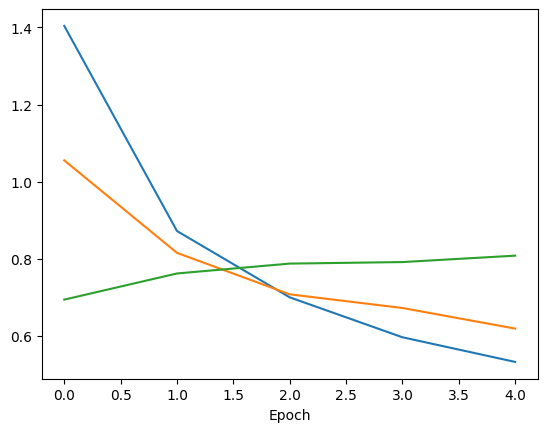

Russian
Arabic
Japanese
Dutch


In [ ]:
import time
import matplotlib.pyplot as plt

BATCH_SIZE = 128
NUM_EPOCHS = 5
LEARNING_RATE = 0.01
HIDDEN_SIZE = 64


train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)


rnn = NamesClassifier(
    input_size=len(names_dataset.index_to_token),
    hidden_size=HIDDEN_SIZE,
    output_size=len(names_dataset.countries),
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)

print("Starting training...")
print(rnn)

train_losses = []
test_losses = []
accuracies = []
for epoch in range(NUM_EPOCHS):
    start_time = time.perf_counter_ns()
    train_loss = train(rnn, train_dataloader, optimizer, criterion)
    test_loss, accuracy = evaluate(rnn, test_dataloader, criterion)
    end_time = time.perf_counter_ns()
    elapsed_time = (end_time - start_time) / 1e9
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    print(
        f"{epoch}  ({epoch / NUM_EPOCHS:.0%}) \t{elapsed_time:.2f}s\tTrain Loss: {train_loss:.2f}\tTest Loss: {test_loss:.2f}\tAccuracy: {accuracy:.2f}"
    )

print("Training complete.")

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.plot(accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.show()

print(predict(rnn, "John"))
print(predict(rnn, "Maria"))
print(predict(rnn, "Yuki"))
print(predict(rnn, "Sven"))